In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [ ]:
data = pd.read_csv('C:/Users/leemi/Desktop/ATC/ATC-project/SEHA_Data_for_Modeling/Heating/2024_df_heat_final.csv')

data = data[['RTU_08_Occupancy_Status', 'RTU_08_Discharge_Air_Temperature_Active',  
             'RTU_8_SFAN_STATUS', 'Month', 'Day', 'Hour', 'Is_Weekday', 
             'RTU_08_Space_Temperature_Active', 'RTU_08_Heat_Primary_Capacity_Status',
             'RTU_08_Outdoor_Air_Temperature_Active', 'RTU_08_Space_Temperature_Setpoint_Active',
             'RTU_08_Space_Temperature_Setpoint_BAS']]

y = data['RTU_08_Space_Temperature_Active']

T = y 
T_out = data['RTU_08_Outdoor_Air_Temperature_Active']
u = data['RTU_08_Heat_Primary_Capacity_Status']

x_external = data[['RTU_08_Occupancy_Status', 'RTU_08_Discharge_Air_Temperature_Active', 
                   'RTU_8_SFAN_STATUS', 'Month', 'Day', 'Hour', 'Is_Weekday', 
                   'RTU_08_Space_Temperature_Setpoint_Active', 'RTU_08_Space_Temperature_Setpoint_BAS']]

T_train, T_test, T_out_train, T_out_test, u_train, u_test, x_external_train, x_external_test, y_train, y_test = train_test_split(
    T, T_out, u, x_external, y, test_size=0.2, random_state=42
)

T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32).view(-1, 1)
T_test_tensor = torch.tensor(T_test.values, dtype=torch.float32).view(-1, 1)
T_out_train_tensor = torch.tensor(T_out_train.values, dtype=torch.float32).view(-1, 1)
T_out_test_tensor = torch.tensor(T_out_test.values, dtype=torch.float32).view(-1, 1)
u_train_tensor = torch.tensor(u_train.values, dtype=torch.float32).view(-1, 1)
u_test_tensor = torch.tensor(u_test.values, dtype=torch.float32).view(-1, 1)
x_external_train_tensor = torch.tensor(x_external_train.values, dtype=torch.float32)
x_external_test_tensor = torch.tensor(x_external_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
class PhysicalModel:
    def __init__(self):
        self.a = nn.Parameter(torch.tensor(0.1)) 
        self.b = nn.Parameter(torch.tensor(0.05)) 

    def predict(self, T, u, T_out, f_nn_output):
        return T + self.a * u - self.b * (T - T_out) + f_nn_output

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.physical_model = PhysicalModel()  
        self.neural_net = SimpleNN(input_dim=len(x_external.columns), output_dim=1)  

    def forward(self, T, u, T_out, x_external):
        f_nn_output = self.neural_net(x_external)
        T_next_pred = self.physical_model.predict(T, u, T_out, f_nn_output)
        return T_next_pred

In [ ]:
import torch.optim as optim
import time

learning_rate = 0.001
num_epochs = 300

pinn_model = PINNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(list(pinn_model.neural_net.parameters()) + 
                       [pinn_model.physical_model.a, pinn_model.physical_model.b], lr=learning_rate)

start_time = time.time()

for epoch in range(num_epochs):
    pinn_model.train()  
    
    T_next_pred = pinn_model(T_train_tensor, u_train_tensor, T_out_train_tensor, x_external_train_tensor)
    
    loss = criterion(T_next_pred, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, a: {pinn_model.physical_model.a.item():.4f}, b: {pinn_model.physical_model.b.item():.4f}')

end_time = time.time()

elapsed_time = end_time - start_time
print(f'Training completed in: {elapsed_time:.2f} seconds')

Epoch [100/300], Loss: 1.0553, a: 0.0400, b: 0.0335
Epoch [200/300], Loss: 0.3474, a: 0.0240, b: 0.0241
Epoch [300/300], Loss: 0.1394, a: 0.0148, b: 0.0154
Training completed in: 1.26 seconds


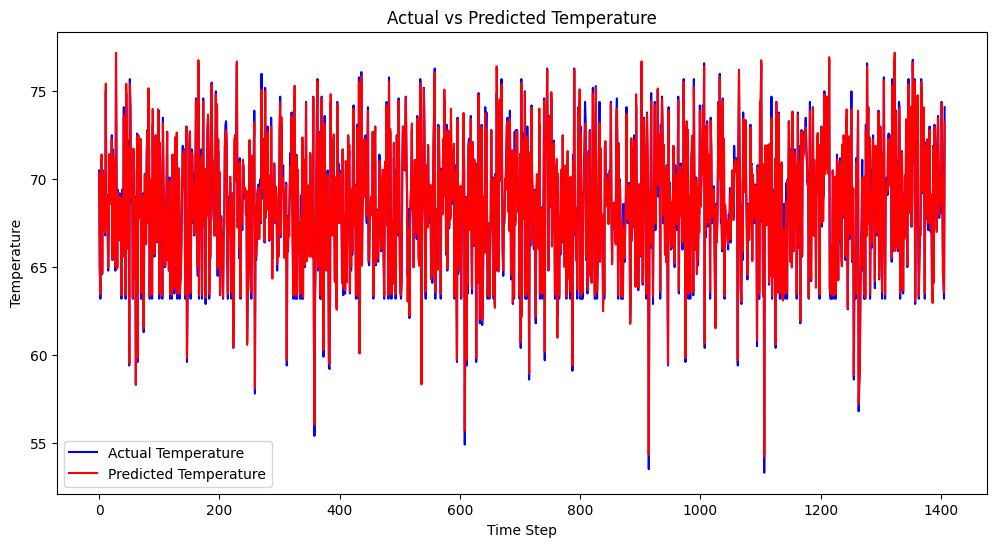

In [ ]:
import matplotlib.pyplot as plt

pinn_model.eval()

with torch.no_grad():  
    T_pred_test = pinn_model(T_test_tensor, u_test_tensor, T_out_test_tensor, x_external_test_tensor)

y_test_np = y_test_tensor.numpy()
T_pred_test_np = T_pred_test.numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label='Actual Temperature', color='b')
plt.plot(T_pred_test_np, label='Predicted Temperature', color='r')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

In [ ]:
import numpy as np

y_test_np = y_test_tensor.numpy()
T_pred_test_np = T_pred_test.numpy()

def calculate_cvrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    cvrmse = rmse / np.mean(y_true) * 100  
    return cvrmse

def calculate_nmbe(y_true, y_pred):
    mbe = np.mean(y_true - y_pred)
    nmbe = mbe / np.mean(y_true) * 100  
    return nmbe

cvrmse = calculate_cvrmse(y_test_np, T_pred_test_np)
nmbe = calculate_nmbe(y_test_np, T_pred_test_np)

print(f'CV(RMSE): {cvrmse:.2f}%')
print(f'NMBE: {nmbe:.2f}%')

CV(RMSE): 0.55%
NMBE: 0.01%
